<div class="alert alert-success">
<h1>SETUP</h1>
</div>

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

## Read in file and save as dictionary

In [2]:
# initialize variables
my_dict = dict()
reviews = []
categories = []
ct = 0
keywords=['Id','ASIN','title','group','salesrank','similar','categories','reviews']

with open('amazon-meta.txt') as file:
    for line in file:
        ct+=1
        # only keep single spaces
        line = ' '.join(line.split())

        # remove empty lines and first two lines
        if not line == '' and ct >= 2 :

            # assign key
            key = line.split(':')[0]

            # assign entry (removing extra white space)
            entry = line.replace(key + ':','').strip()

            if key in keywords:
                if key == 'Id':

                    # save reviews from previous item
                    if reviews != []:
                        my_dict[prev_id]['reviews_all'] = reviews
                    # save categories from previous item
                    if categories != []:
                        my_dict[prev_id]['cats_all'] = categories

                    # add new ID to dictionary
                    my_dict[entry] = dict()
                    prev_id = entry
                    reviews = []
                    categories = []
                else:
                    my_dict[prev_id][key] = entry

            # if line contains a review, add to review list
            elif ('helpful' in entry) and ('votes' in entry):
                reviews.append(entry)

            # if line contains categories, add to categories list
            elif line[0] == '|':
                categories.append(entry)

## Convert dictionary to dataframe

In [3]:
df = pd.DataFrame.from_dict(my_dict, orient='index')
df.head()

,ASIN,title,group,salesrank,similar,categories,reviews,reviews_all,cats_all
0,0771044445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0827229534,Patterns of Preaching: A Sermon Sampler,Book,396585,5 0804215715 156101074X 0687023955 0687074231 ...,2,total: 2 downloaded: 2 avg rating: 5,[A2JW67OY8U6HHK rating: 5 votes: 10 helpful: 9...,[|Books[283155]|Subjects[1000]|Religion & Spir...
10,0375709363,The Edward Said Reader,Book,220379,5 039474067X 0679730672 0679750541 1400030668 ...,3,total: 6 downloaded: 6 avg rating: 4,[A2RI73IFW2GWU1 rating: 4 votes: 12 helpful: 7...,[|Books[283155]|Subjects[1000]|Literature & Fi...
100,0787958743,Guide to Effective Staff Development in Health...,Book,783690,5 1886624089 0397554168 1560535253 0875847471 ...,2,total: 0 downloaded: 0 avg rating: 0,NaN,[|Books[283155]|Subjects[1000]|Medicine[13996]...
1000,0830815627,Invitation to Theology,Book,497795,5 0830814493 0687095735 0801090962 0960263845 ...,1,total: 1 downloaded: 1 avg rating: 5,[A2C67F0TPHMI7D rating: 5 votes: 3 helpful: 3],[|Books[283155]|Subjects[1000]|Religion & Spir...


<div class="alert alert-success">
<h1>PART A</h1>
</div>

## 1: Trustworthiness of ratings

### Code

**Create subset dataframe and do basic cleaning**

In [59]:
# create subset dataframe with just reviews
df_revs = df[['reviews', 'reviews_all', 'group', 'salesrank']]

# remove rows without review data
df_revs = df_revs[pd.notnull(df_revs['reviews'])]

# convert 'reviews' column to list
df_revs['reviews'] = df_revs['reviews'].str.split()

# make columns for each review component
df_revs['total'] = df_revs.apply(lambda row: row.reviews[1], axis=1)
df_revs['downloaded'] = df_revs.apply(lambda row: row.reviews[3], axis=1)
df_revs['avg_rating'] = df_revs.apply(lambda row: row.reviews[6], axis=1)

# convert columns to numeric
df_revs['total'] = pd.to_numeric(df_revs['total'])
df_revs['downloaded'] = pd.to_numeric(df_revs['downloaded'])
df_revs['avg_rating'] = pd.to_numeric(df_revs['avg_rating'])
df_revs['salesrank'] = pd.to_numeric(df_revs['salesrank'])

# remove rows/products with no reviews (where total = 0)
df_revs = df_revs[df_revs['total'] != 0]

**Graph number of products by rating**

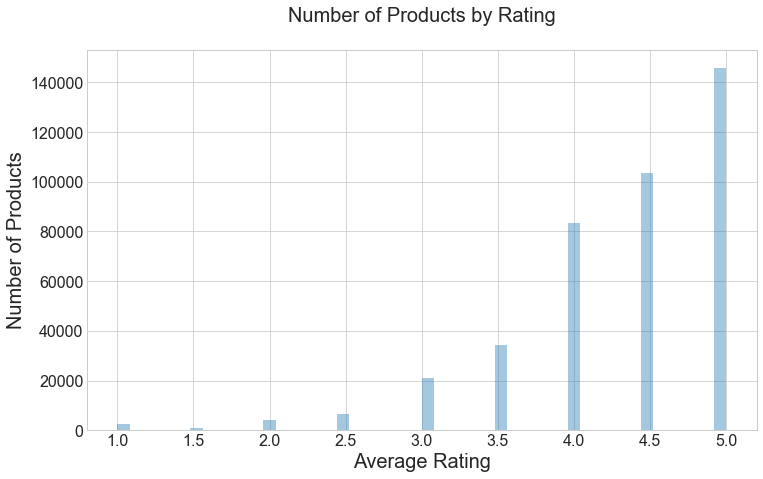

In [60]:
g = sns.distplot(df_revs['avg_rating'], kde=False)
g.figure.set_size_inches(12,7)
g.axes.set_title('Number of Products by Rating\n', fontsize=20)
g.set_xlabel('Average Rating', size=20)
g.set_ylabel('Number of Products', size=20)
g.tick_params(labelsize=16)

**Calculate proportion of ratings that are 1 and 5**

In [61]:
prop_one = round(len(df_revs[df_revs.avg_rating == 1])/len(df_revs) * 100,1)
prop_five = round(len(df_revs[df_revs.avg_rating == 5])/len(df_revs) * 100,1)

**Perform shapiro-wilk test for normality**

In [62]:
from scipy import stats

W, p = stats.shapiro(df_revs.avg_rating)
print('W = {:.2f}, p = {:.10f}'.format(W, p))

W = 0.82, p = 0.0000000000


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/scipy/stats/morestats.py:1326: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


**Create dataframe to look at individual reviews**

In [11]:
# remove rows without review data
df_revs = df_revs[pd.notnull(df_revs['reviews_all'])]

rows_list = []
    
for i in range(0,len(df_revs)):
    curr_val = df_revs.iloc[i,1]
    for j in range(0,len(curr_val)):    
        new_str = df_revs.iloc[i,1][j].split()
        dict1 = {}
        dict1['review_id'] = new_str[0]
        dict1['rating'] = new_str[2]
        dict1['votes'] = new_str[4]
        dict1['helpful'] = new_str[6]

        rows_list.append(dict1)

df_revs2 = pd.DataFrame(rows_list)

# convert relevant columns to numeric
df_revs2['helpful'] = pd.to_numeric(df_revs2['helpful'])
df_revs2['votes'] = pd.to_numeric(df_revs2['votes'])
df_revs2['rating'] = pd.to_numeric(df_revs2['rating'])

**Examine mean helpfulness and votes by rating**

In [49]:
print('Mean Helpfulness and Votes by Rating')
df_revs2.groupby(by='rating').mean().round(2)

Mean Helpfulness and Votes by Rating


,helpful,votes
rating,,
1,5.12,13.77
2,4.30,9.18
3,3.40,6.04
4,3.28,4.52
5,3.79,4.93


In [51]:
from statsmodels.formula.api import ols

m = ols('helpful ~ rating', df_revs2).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                helpful   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4365.
Date:                Wed, 29 Nov 2017   Prob (F-statistic):               0.00
Time:                        13:02:32   Log-Likelihood:            -2.8965e+07
No. Observations:             7593243   AIC:                         5.793e+07
Df Residuals:                 7593241   BIC:                         5.793e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6744      0.014    336.381      0.0

<div class="alert alert-warning">
<h3>Response: Part A, Question 1</h3>
</div>

As the graph *"Number of Products by Rating"* shows, the ratings are not normally distributed.  Rather, they are skewed toward the positive end: many more products receive average ratings of 5 ({{prop_five}}%) than average ratings of 1 ({{prop_one}}%).  The fact that the distribution of ratings isn't normal is confirmed by the Shapiro-Wilk test for normality, as shown above (p < .0001).

In addition, the table *"Mean Helpfulness and Votes by Rating"* indicates that ratings of 1 and 2 are deemed to be the most helpful by customers, on average.  An ANOVA confirms that there is a significant difference between how helpful the review is and its rating, F(1, 7,593,241) = 4365, p < .0001).

Given the fact that higher ratings are more frequent but generally less helpful, it suggests that some of these high ratings are uninformative and perhaps even fraudulent.  For example, it's possible that some companies are fabricating positive reviews that are then deemed unhelpful by customers.

## 2. Category bloat

### Code

In [54]:
# create subset df with just books and relevant columns
df_books = df[df['group'] == 'Book']
df_books = df_books[['ASIN', 'group', 'salesrank', 'categories', 'cats_all']]

# remove rows without category data
df_books = df_books[pd.notnull(df_books['categories'])]

df_books.head()

,ASIN,group,salesrank,categories,cats_all
1,0827229534,Book,396585,2,[|Books[283155]|Subjects[1000]|Religion & Spir...
10,0375709363,Book,220379,3,[|Books[283155]|Subjects[1000]|Literature & Fi...
100,0787958743,Book,783690,2,[|Books[283155]|Subjects[1000]|Medicine[13996]...
1000,0830815627,Book,497795,1,[|Books[283155]|Subjects[1000]|Religion & Spir...
10000,1589600282,Book,1544234,3,[|Books[283155]|Subjects[1000]|Religion & Spir...


**Make dictionary of categories and number of products in each**

In [55]:
cats_dict = dict()
col = df_books.columns.get_loc('cats_all') # get col # for cats_all column

for row in range(0, len(df_books)):
    if type(df_books.iloc[row,col]) == list:
        for category in df_books.iloc[row,4]:
            if category in cats_dict:
                cats_dict[category] += 1
            else:
                cats_dict[category] = 1

**Create dataframe of number of books and number of categories**

For example: 1,036 categories only contain 1 book

In [56]:
import itertools

# create dictionary with number of books and number of categories
temp_dict = [(k, len(list(v))) for k, v in itertools.groupby(sorted(cats_dict.values()))]

# create dataframe from above dictionary
df_books_cats = pd.DataFrame.from_dict(temp_dict)
df_books_cats = df_books_cats.rename(columns={0: 'num_books', 1: 'num_cats'})
df_books_cats.head()

,num_books,num_cats
0,1,1036
1,2,734
2,3,628
3,4,491
4,5,461


**Calculate values for response**

In [57]:
# calculate number of categories to be removed
num_cats_to_remove = sum(df_books_cats[df_books_cats['num_books'] <= 2]['num_cats'])

# calculate percentage of total categories to be removed
prop_cats_to_remove = 100*((num_cats_to_remove)/len(cats_dict))

# calculate number of all category entries in dataset
df_books['categories'] = pd.to_numeric(df_books['categories'])
all_cat_entries = sum(df_books['categories'])

# calculate percentage of total category entries to be removed
cat_entries_to_remove = (734*2)+1036
prop_entries_to_remove = 100*(cat_entries_to_remove / all_cat_entries)

<div class="alert alert-warning">
<h3>Response: Part A, Question 2</h3>
</div>

**a.** Yes, there appears to be some degree of category bloat.  There are 1,036 categories that contain only 1 book each, while a single category contains 18,438 books.

**b.** If I remove categories with only one book within the category (1,036) or two books within the category (734), that would correspond to {{'{:.2f}%'.format(prop_cats_to_remove)}} of all categories ({{'{:,}'.format(len(cats_dict))}}).  That would also correspond to 2,504 category entries (1,036 + 734\*2), which is only {{'{:.2f}%'.format(prop_entries_to_remove)}} of the total number of category entries ({{'{:,}'.format(all_cat_entries)}}).

After removing these unnecessary categories, the books in those categories could be put into the next highest category.  For example, if a book was in the *Literature & Fiction|Drama|United States* category, but that category was removed, the book could be put instead into the *Literature & Fiction|Drama* category.

<div class="alert alert-success">
<h1>PART B</h1>
</div>

<div class="alert alert-warning">
<h2>Algorithm thinking</h2>
</div>

I would use clustering to identify groups of products that are similar or tend to be purchased together.  In particular, a method that can identify hierarchical clusters would be best suited to the task.

<div class="alert alert-warning">
<h2>Product thinking</h2>
</div>

**A.** I think it is a good idea to show users the categorization hierarchy for items because it allows them to more easily identify other similar items that they might like to purchase.  For example, if they find a book in the *Literature & Fiction|Drama|United States* category, they can easily click on "Drama" to find books they might not have otherwise found.  To test this hypothesis, I would use A/B testing and show one group of people the hierarchy and another group of people no hierarchy.  I could then see which group is more likely to buy the current product as well as similar products.

**B.** I think it is a good idea to show users similar or co-purchased items because it can show them similar products to consider buying or products that might be useful to buy along with the current product.  For example, if they are purchasing something that requires batteries, and the co-purchased items include batteries, they may be more likely to remember to buy them.  As above, I would use A/B testing to test this hypothesis.  One group of people would see similar/co-purchased products and another group would not.  Then I would compare the proportion of users in each group that purchased the current item as well as similar/co-purchased items.

**C.** I think it is a good idea to show users reviews/ratings for items because it allows them to identify the best product for their needs.  That is, they can identify the best-rated products as well as read about aspects of the products mentioned in the reviews that they may be curious about.  Again, as above, I would use A/B testing to evaluate this hypothesis.  One group of people would see reviews while another group would not.  I would then compare the proportion of users in each group that purchased the current product.